# Introduction
(10 marks)

## Background
*(1 paragraph of at least 6 lines)*

The original 16 categories are: 
1. Admin, HR, CS, Office Support
2. Marketing, Sales
3. Media, Communcation
4. Finance, Accounting
5. Information Technology
6. Education, Training
7. Social Services
8. Healthcare, Medical
9. Science, Research
10. Construction, Artisans, Skilled Trade
11. Legal, Security, Law Enforcement
12. Hospitality, Tourism
13. Transport, Logistics
14. Internships, Fellowships, Scholarships
15. Entertainment, Arts, Sports
16. Unknown

- Original data = 59986 rows
- Consulted 5 HR professionals to get meaningful buckets to form the job categories labeling dataset. 
- Narrowed down to the top 5 using a sample of 1000 records from 2018

## Research Problem
Without revealing the tally statistics from the sample data, I asked them to hypothesize about which 3 had the highest demand as evidenced by job advertisements. Asked whether they think this trend changed was affected by COVID.

## Objectives
- Develop a text classification model based on the support vector machine (SVM) algorithm that assigned job category labels to the corresponding job descriptions.
- Use the model as a self-training semi-supervised model to transform a subset the original unlabeled dataset into a labeled dataset that includes at least 5000 rows. 
- Iteratively train the model on new chunks of data to accurately categorize job descriptions into the top 5 of the original 16 predefined categories (targets) based on their text content.
- Achieve a classification accuracy of at least 85% ensuring that the model reliably differentiates between the job categories.

- *(TODO: Add a 3rd and possible a 4th from SMART)*

## Hypothesis
*(At least 2 points)*

Ho1: HR, IT, and Marketing are not the categories that are highest in demand. 
Ha1: HR, IT, and Marketing are the categories that are highest in demand.

Ho2: The categories present in the top 3 were not affected by COVID. 
Ha2: The categories present in the top 3 were affected by COVID.

# Methodology, Results, and Discussion

## Data description 
1 paragraph of at least 10 lines with variables described in a table
- Source of data 
- Period collected (year and month/day) 
- How it was collected 
- Under what conditions was it collected
(10 marks)


Notes:
- Text classification using a SVM model
- 3 steps: scrap, label, train
- Scrap data from website
- The scraping code written and data collected between July 1st and July 14th
- I fetched the data one month at a time then combined it into a single spreadsheet
- The Notebook is in the following location:
- I consulted 2 HR professionals on how to cluster the dataset into meaningful buckets
- This is supervised learning. Since the original data was unlabeled, I applied semi-supervised learning
- I labelled the data manually until I hit an accuracy of 64% - this happened at the 1129 rows mark - then iteratively trained the model to predict the rest. The semi-supervised training notebook is the following location
- I did 100 at a time until the accuracy got to 75%, then 500 at a time, and then 1000 until I reached an accuracy of 90%
- Text cleaning involved only including descriptions whose character count was less than 10000. The job descriptions in this case were substituted with the number. Any job descriptions with images were left blank. This explains the missing values

## Import Packages

In [1]:
# If absent, uncomment to install the following required packages
# pip pandas numpy scikit-learn nltk matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import re as regex
import nltk
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.semi_supervised import LabelPropagation
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from pathlib import Path

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load data

There are 2 sets of labeled data:
1. Sample dataset - the first 1000 job descriptions classified into the original 16 job categories
2. Final dataset - n job descriptions classified into the final 5 job descriptions

In [38]:
def load_sample_labeled_data():
    data_folder_name = 'data'
    sample_labeled_data_file_name = 'sample_labeled_data.csv'
    
    sample_labeled_data_file_path = os.path.join(os.getcwd(), data_folder_name, sample_labeled_data_file_name)
    
    return pd.read_csv(sample_labeled_data_file_path)

original_sample_labeled_data = load_sample_labeled_data()
original_sample_labeled_data.shape

(1521, 5)

In [40]:
def load_final_labeled_data():
    data_folder_name = 'data'
    final_labeled_data_file_name = 'final_labeled_data.csv'
    
    final_labeled_data_file_path = os.path.join(os.getcwd(), data_folder_name, final_labeled_data_file_name)
    
    return pd.read_csv(final_labeled_data_file_path)

original_final_labeled_data = load_final_labeled_data()
original_final_labeled_data.shape

(2125, 5)

**Toggle to choose whether to load the sample or final labeled data**

In [41]:
is_final_data = True

In [42]:
def load_labeled_data(should_load_final_data):
    if should_load_final_data:
        return original_final_labeled_data
    else:
        return original_sample_labeled_data

original_labeled_df = load_labeled_data(is_final_data)
original_labeled_df.head(1)

,TITLE,LINK,JOB DESCRIPTION,DATE,CATEGORY
0,Tuskys Supermarket Are Hiring,https://opportunitiesforyoungkenyans.co.ke/201...,"This last week of January, Tuskys supermarket ...",1/26/2018,Other


In [43]:
original_labeled_df.shape

(2125, 5)

## Exploratory data analytics 
with visualizations and interpretations; new hind insights 
- Descriptive analytics
- Diagnostics analytics
(10 marks)


Ideas:
1. Analyze the distribution of job titles and categories
2. Visualize the most common words and phrases using word clouds or bar charts.

In [44]:
original_labeled_df.head(3)

,TITLE,LINK,JOB DESCRIPTION,DATE,CATEGORY
0,Tuskys Supermarket Are Hiring,https://opportunitiesforyoungkenyans.co.ke/201...,"This last week of January, Tuskys supermarket ...",1/26/2018,Other
1,Admin Assistant Job Opportune,https://opportunitiesforyoungkenyans.co.ke/201...,We are looking to hire an administrative assis...,1/25/2018,"Admin, HR, CS, Office Support"
2,KPC Hiring Graduate Trainees,https://opportunitiesforyoungkenyans.co.ke/201...,MANAGEMENT TRAINEE Vacancy Reference: MANAGEME...,1/24/2018,"Internships, Fellowships, Scholarships"


In [45]:
original_labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TITLE            2125 non-null   object
 1   LINK             2125 non-null   object
 2   JOB DESCRIPTION  2125 non-null   object
 3   DATE             2125 non-null   object
 4   CATEGORY         2125 non-null   object
dtypes: object(5)
memory usage: 83.1+ KB


## Data cleaning / pre-treatment for ML

### Check for missing values
TODO: Give the reason they are missing.

In [46]:
def remove_missing_values(df):
    missing_values = df.isnull().sum()
    print(f'Total missing values before cleaning: \n{missing_values}\n')
    
    clean_df = df.dropna()
    print(f'Total missing values after cleaning: \n{clean_df.isnull().sum()}\n')
    
    return clean_df

### Removing Duplicates

In [47]:
def remove_duplicates(df):
    duplicates = df[df['JOB DESCRIPTION'].duplicated(keep='first')]['JOB DESCRIPTION']
    print(f'Total duplicated records: \n{duplicates.count()}\n')

    clean_df = df.drop_duplicates(subset='JOB DESCRIPTION', keep='first')
    print(f'Total unique records: \n{clean_df.count()}\n')
    
    return clean_df

### Cleaning data

In [48]:
def clean_data(df):
    labeled_df_without_missing_values = remove_missing_values(df)
    return remove_duplicates(labeled_df_without_missing_values)

labeled_df = clean_data(original_labeled_df)

Total missing values before cleaning: 
TITLE              0
LINK               0
JOB DESCRIPTION    0
DATE               0
CATEGORY           0
dtype: int64

Total missing values after cleaning: 
TITLE              0
LINK               0
JOB DESCRIPTION    0
DATE               0
CATEGORY           0
dtype: int64

Total duplicated records: 
360

Total unique records: 
TITLE              1765
LINK               1765
JOB DESCRIPTION    1765
DATE               1765
CATEGORY           1765
dtype: int64



In [49]:
def clean_category_data(text):
  text = text.lstrip().rstrip()
  return text

cleaned_original_labeled_df = labeled_df.copy()
clean_category_data = cleaned_original_labeled_df['CATEGORY'].apply(clean_category_data)
cleaned_original_labeled_df['CATEGORY'] = clean_category_data

In [50]:
cleaned_original_labeled_df['CATEGORY'].value_counts()

CATEGORY
Other                                     901
Internships, Fellowships, Scholarships    444
Admin, HR, CS, Office Support             137
Marketing, Sales                          118
Finance, Accounting                        83
Information Technology                     82
Name: count, dtype: int64

In [51]:
cleaned_labeled_df = cleaned_original_labeled_df.iloc[:, [2, 4]]
cleaned_labeled_df.head(3)

,JOB DESCRIPTION,CATEGORY
0,"This last week of January, Tuskys supermarket ...",Other
1,We are looking to hire an administrative assis...,"Admin, HR, CS, Office Support"
2,MANAGEMENT TRAINEE Vacancy Reference: MANAGEME...,"Internships, Fellowships, Scholarships"


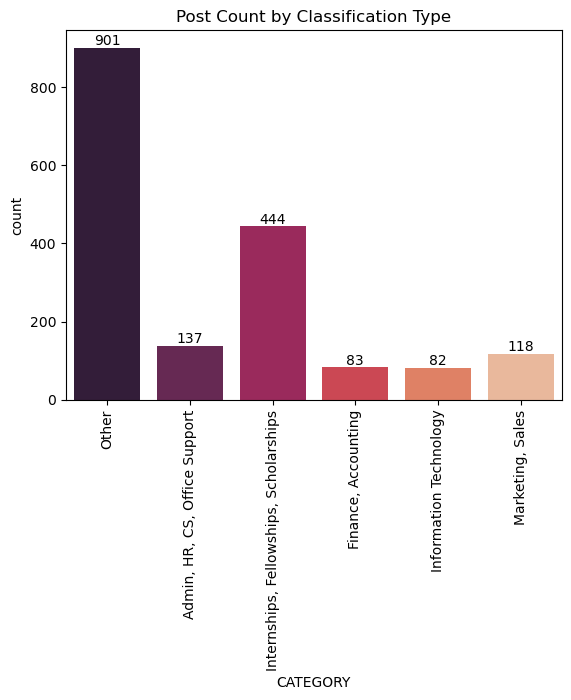

In [52]:
defined_categories = cleaned_labeled_df['CATEGORY'][cleaned_labeled_df['CATEGORY'] != 'Unknown']

ax = sns.countplot(x = defined_categories, palette = 'rocket', hue = defined_categories, legend = False)

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=90)
plt.title("Post Count by Classification Type")
plt.show()

In [53]:
def preprocess_text(text, custom_stopwords):
  text = regex.sub('[^a-zA-Z]', ' ', text).lower()
 
  words = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  stop_words.update(custom_stopwords)

  words = [word for word in words if word not in stop_words]

  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in words]

  text = ' '.join(words)
  return text

In [54]:
custom_stopwords = ['kenya', 'job', 'application', 'apply', 'email', 'year', 'work', 'skill', 'position', 'ensure', 'kenya', 'http', 'candidate', 'program', 'staff', 'www', 'cv', 'experience']
df = cleaned_labeled_df.copy()
df['Cleaned Job Description'] = df['JOB DESCRIPTION'].apply(preprocess_text, custom_stopwords=custom_stopwords)

### Word Frequency Analysis

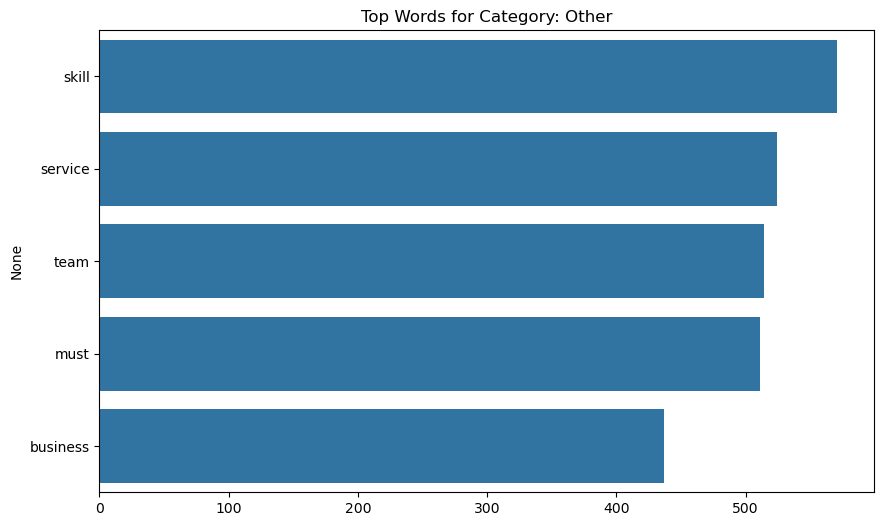

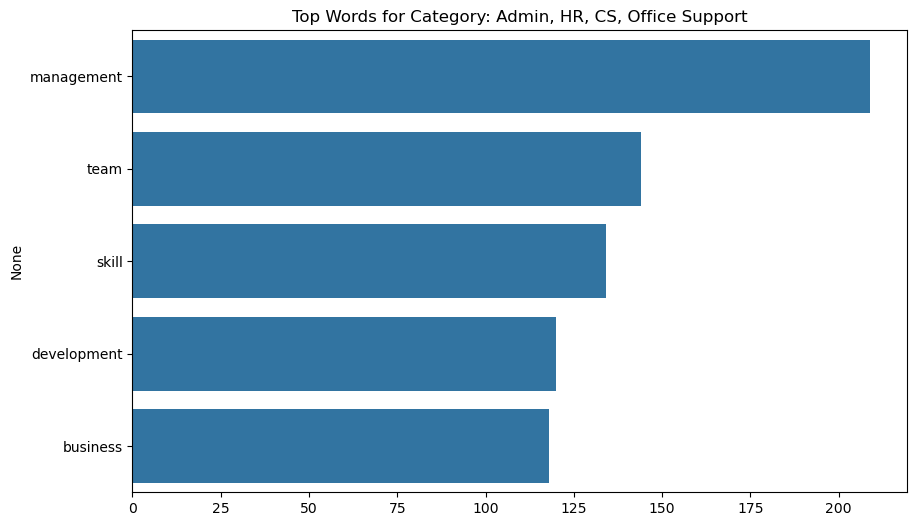

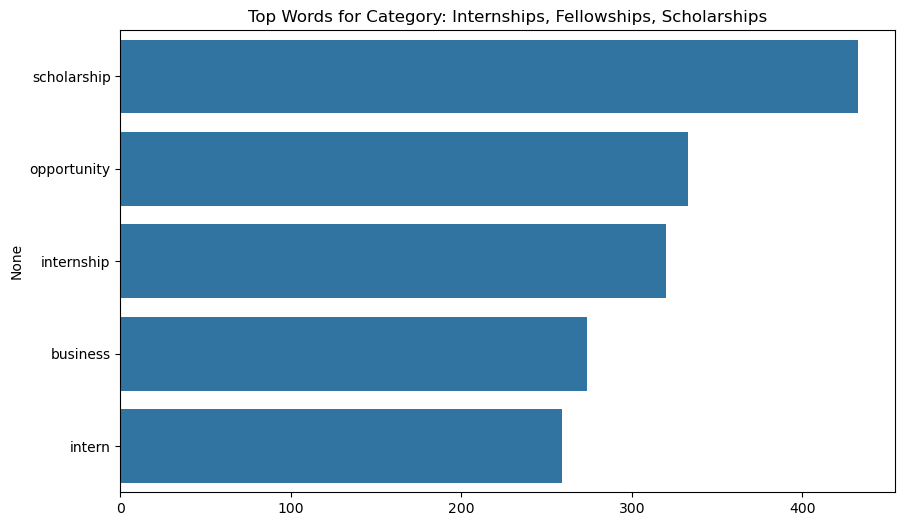

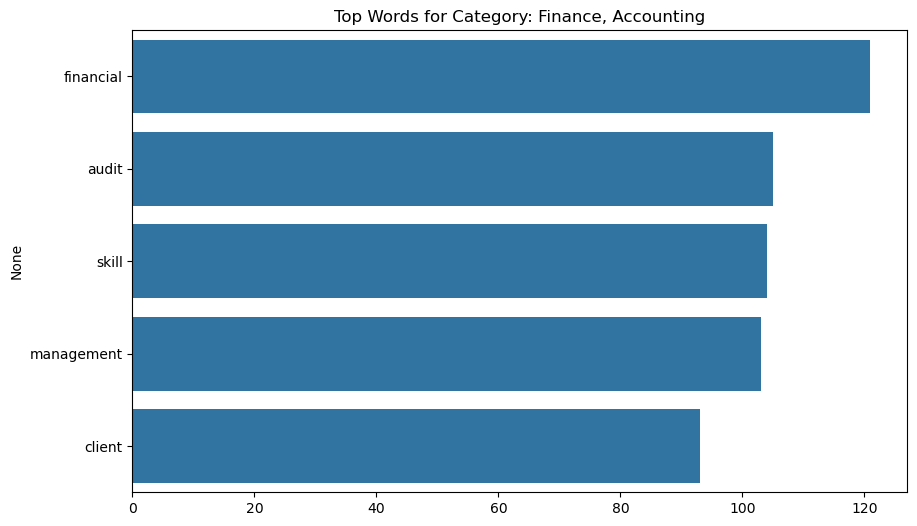

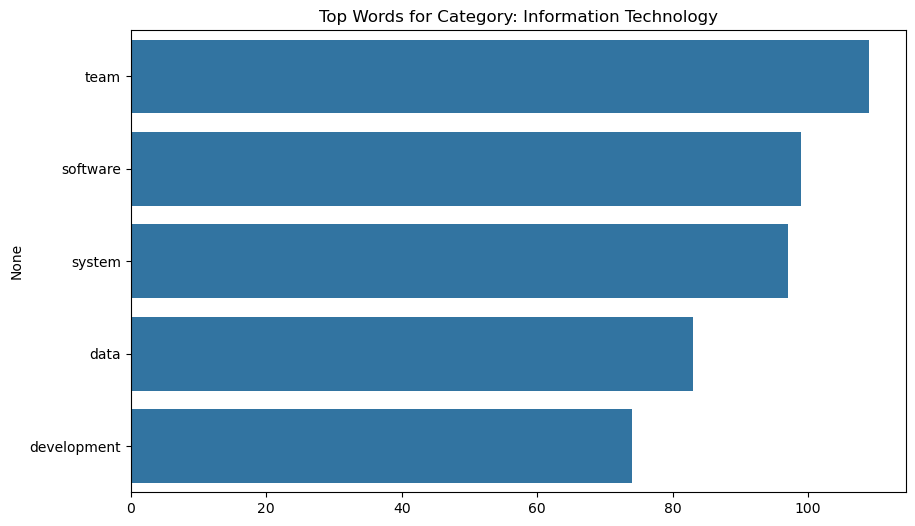

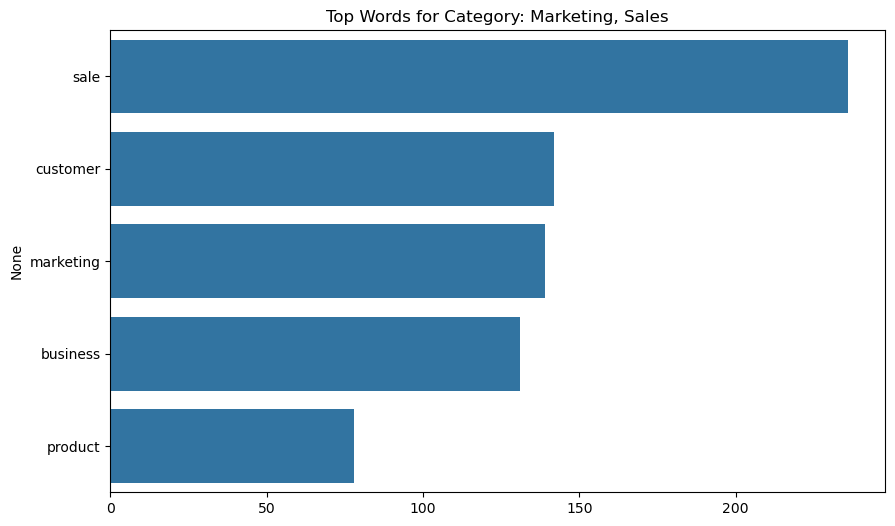

In [55]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Cleaned Job Description'])

# Convert the sparse matrix to a DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate word frequencies per category
word_counts = pd.concat([df['CATEGORY'], X_df], axis=1).groupby('CATEGORY').sum()

# Visualize top words for each category
for category in df['CATEGORY'].unique():
    top_words = word_counts.loc[category].sort_values(ascending=False).head()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_words.values, y=top_words.index)
    plt.title(f'Top Words for Category: {category}')
    plt.show()

Split the data using the 80/20 split into training and testing sets 

*NB to self (to remove later). Use random_state to guarantees that the same data points will be assigned to the training and validation sets every time the code is run. This maintains consistency.*

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned Job Description'], df['CATEGORY'], test_size=0.2, random_state=41, stratify=df['CATEGORY'])

### Feature Engineering
Using Term Frequency-Inverse Document Frequency to convert text data into numerical features.

In [61]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Create model and perform hyperparameter tuning
This uses Grid Search

In [62]:
# Define the parameter grid for grid search
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 10]}

# Create the SVM model
svm_model = SVC()

# Create the grid search object
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

### Evaluate model

In [63]:
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred)) 

Accuracy: 0.7507082152974505
                                        precision    recall  f1-score   support

         Admin, HR, CS, Office Support       0.86      0.22      0.35        27
                   Finance, Accounting       0.90      0.53      0.67        17
                Information Technology       1.00      0.31      0.48        16
Internships, Fellowships, Scholarships       0.82      0.76      0.79        89
                      Marketing, Sales       0.74      0.58      0.65        24
                                 Other       0.71      0.91      0.80       180

                              accuracy                           0.75       353
                             macro avg       0.84      0.55      0.62       353
                          weighted avg       0.77      0.75      0.73       353



# Supplementary work
This is secondary work related to the project. It includes:
1. Web scraping to retrieve the unlabeled data
2. Semi-supervised labelling of the primary data
3. Recategorization of the least populated job categories

The code for each is available below for quick reference. The individual notebooks are also present in the same folder as this notebook for isolated review.

## A. Scraping the unlabeled data

In [ ]:
import requests
import unicodedata
import os
import pandas as pd

from bs4 import BeautifulSoup
from urllib.parse import urlparse
from datetime import date
from pathlib import Path

**Normalize Unicode characters**

In [ ]:
def clean_text(text):
    cleaned_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return cleaned_text

**Isolate job description**

In [ ]:
def get_post_body(url, headers):
  response = requests.get(url, headers=headers)

  if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    section = soup.find('section', class_='main-content')

    if section:
      post_article = section.find('article', class_='post-content')
      if post_article:
        # post_container = post_article.find('div', class_='clearfix').text
        post_container = post_article.find('div', class_='clearfix')
        
        if post_container:
          post_container_text =  clean_text(post_container.get_text(separator=" ", strip=True))

          if len(post_container_text) > 10000:
            post_container_text = len(post_container_text)
            
          return post_container_text

**Isolate date**

In [ ]:
def extract_date_from_url(url):
  parsed_url =  urlparse(url)
  
  path_parts = parsed_url.path.split('/')
  
  year = path_parts[1]
  month = path_parts[2]
  day = path_parts[3]
  
  date = f'{year}-{month}-{day}'
  return date

**Retrieve job post records**

In [ ]:
def get_job_postings(url, headers):
  response = requests.get(url, headers=headers)

  if response.status_code == 200:
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.content, 'html.parser')
    section = soup.find('section', class_='main-content')

    if section:
      post_container = section.find('div', class_='col-lg-8')

      job_posts = []
      
      for post in post_container.find_all('div', class_='post-classic'):
        title_heading_element = post.find('h5')

        title = clean_text(title_heading_element.find('a').text.strip())
        link = title_heading_element.find('a').get("href")

        content = get_post_body(link, headers)
        date = extract_date_from_url(link)

        job_posts.append({
          'title': title,
          'link': link,
          'content': content,
          'date': date
        })
      return job_posts
  else:
    return []

**Save job post data by month**

In [ ]:
def aggregate_job_postings():
  headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
  }

  data_folder = Path('data')
  data_folder.mkdir(parents=True, exist_ok=True)

  first_year = 2018
  first_month = 1

  date_today = date.today()
  year_today = date_today.year
  month_today = date_today.month

  base_url = 'https://opportunitiesforyoungkenyans.co.ke'

  jobs_from_all_dates = []
  merged_jobs = []

  for year in range(first_year, year_today + 1):
    if year == year_today:
      last_month = month_today
    else:
      last_month = 12
    
    for month in range(first_month, last_month + 1):
      current_month_url = f'{base_url}/{year}/{month}'
      current_month_url_response = requests.get(current_month_url, headers=headers)
      print(current_month_url)
      if current_month_url_response.status_code == 200:
        for page_count in range(1, 1000):
          page_url = f'{current_month_url}/page/{page_count}'
          page_url_response = requests.get(page_url, headers=headers)
          
          if page_url_response.status_code == 200:
            page_url_soup = BeautifulSoup(page_url_response.content, 'html.parser')
            page_url_body_tag = page_url_soup.body
            
            if page_url_body_tag and 'error404' in page_url_body_tag.get('class', []):
              print(f'Error 404 found on {page_url}. Stopping search.')
              break # Stop searching further pages because if current page is not found then there are no more pages for this date.
            else:
              jobs_per_date = get_job_postings(page_url, headers)
              jobs_from_all_dates.append(jobs_per_date)
              print(f'Found {page_url}')
          else:
            print(f'Failed to retrieve {page_url}. Status code: {page_url_response.status_code}')
            break  # Stop searching further pages on HTTP error
      else:
        print(f'Failed to retrieve {current_month_url}. Status code: {current_month_url_response.status_code}')
        continue  # Stop searching further pages on HTTP error

      print(f'Month {month} over.')

      for jobs in jobs_from_all_dates:
        merged_jobs.extend(jobs)

      file_name = f'job_postings_{month}-{year}.csv'
      file_path = data_folder / file_name 
        
      df = pd.DataFrame(merged_jobs)
      df.to_csv(file_path, index=False)
        
      print(f'{month}-{year} spreadsheet exported')

      merged_jobs = []
      jobs_from_all_dates = []
        
    print(f'Year {year} over.')     

  print(f'Scraping finished.')  

aggregate_job_postings()

**Combine month files into a common CSV file**

In [ ]:
def combine_files():
    data_folder = Path('data')
    data_folder.mkdir(parents=True, exist_ok=True)

    first_year = 2018
    first_month = 1
    
    date_today = date.today()
    year_today = date_today.year
    month_today = date_today.month

    all_dataframes = []
    
    for year in range(first_year, year_today + 1):
        if year == year_today:
            last_month = month_today
        else:
            last_month = 12
        
        for month in range(first_month, last_month + 1):
            file_name = f'job_postings_{month}-{year}.csv'
            file_path = data_folder / file_name
            
            print(f'Reading file: {file_path}')
            
            try:
                df = pd.read_csv(file_path)
                all_dataframes.append(df)
            except FileNotFoundError:
                print(f'File not found: {file_path}')
                continue

    if all_dataframes:
        file_name = 'complete_unlabeled_data.csv'
        file_path = data_folder / file_name

        combined_df = pd.concat(all_dataframes, ignore_index=True)
        combined_df.to_csv(file_path, index=False)
        print('All files have been combined and saved to /data/complete_unlabeled_data.csv')
    else:
        print('No files were found to combine.')

combine_files()

## B. Self-training

In [23]:
def load_training_data():
    data_folder_name = 'data'
    sample_labeled_data_file_name = 'working-unlabeled-data.csv'
    
    sample_labeled_data_file_path = os.path.join(os.getcwd(), data_folder_name, sample_labeled_data_file_name)
    return pd.read_csv(sample_labeled_data_file_path)

original_unlabeled_df = load_training_data()

In [24]:
original_unlabeled_df.shape

(987, 4)

In [25]:
print(f'Total missing values: {original_unlabeled_df['JOB DESCRIPTION'].isnull().sum()}')

Total missing values: 74


In [26]:
cleaned_unlabeled_df = original_unlabeled_df.dropna(subset=["JOB DESCRIPTION"])
cleaned_unlabeled_df.count()

TITLE              913
LINK               913
JOB DESCRIPTION    913
DATE               913
dtype: int64

In [28]:
unlabeled_df_copy = cleaned_unlabeled_df.copy()
unlabeled_df_copy['Cleaned Job Description'] = unlabeled_df_copy['JOB DESCRIPTION'].apply(preprocess_text, custom_stopwords=custom_stopwords)
unlabeled_df_copy.head()

,TITLE,LINK,JOB DESCRIPTION,DATE,Cleaned Job Description
0,7 Vacant Positions Open At Kenya Airways,https://opportunitiesforyoungkenyans.co.ke/202...,We value every single customer who chooses us ...,7/12/2024,value every single customer chooses u whether ...
1,CPHRM Group Hiring Sales Representatives (Dete...,https://opportunitiesforyoungkenyans.co.ke/202...,Job Responsibilities Identify and pursue new s...,7/12/2024,responsibility identify pursue new sale opport...
2,7 Vacant Positions Open At Safaricom,https://opportunitiesforyoungkenyans.co.ke/202...,At Safaricom we are driven by our Spirit of Pu...,7/12/2024,safaricom driven spirit purpose customer obses...
3,Save The Children Hiring Supply Chain Officer,https://opportunitiesforyoungkenyans.co.ke/202...,Job Title: Supply Chain Officer Turkana Role ...,7/12/2024,title supply chain officer turkana role purpos...
4,Paid Internship Opportunities To Apply In July...,https://opportunitiesforyoungkenyans.co.ke/202...,Paid Internship Opportunities To Apply In July...,7/12/2024,paid internship opportunity july global gradua...


In [36]:
data_folder = Path('data', 'work_in_progress')
data_folder.mkdir(parents=True, exist_ok=True)

In [37]:
unlabeled_features = vectorizer.transform(unlabeled_df_copy['Cleaned Job Description'])

predicted_categories = best_model.predict(unlabeled_features)

unlabeled_df_copy['CATEGORY'] = predicted_categories

file_name = 'predicted_categories_1.csv'
file_path = data_folder / file_name

unlabeled_df_copy.to_csv(file_path, index=False)
print('A new file has been created at /data/predicted_categories.csv')

unlabeled_df_copy = unlabeled_df_copy.drop(columns=['Cleaned Job Description'])

A new file has been created at /data/predicted_categories.csv


At this point I manually look through each record, correct the wrong ones, feed the corrected data to the primary labeled data, train the model, and repeat with the fresh batch of data.

## C. Recategorizing of labelled data
This code below is to be run once after the top 5 job categories have been identified from the sample labeled data.

In [79]:
def contract_categories(df):
    data = [
        'Hospitality, Tourism', 
        'Education, Training', 
        'Legal, Security, Law Enforcement', 
        'Construction, Artisans, SkilledTrade', 
        'Transport, Logistics', 
        'Healthcare, Medical', 
        'Entertainment, Arts, Sports', 
        'Social Services', 
        'Science, Research', 
        'Media & Communication',
        'Unknown'
    ]

    return df['CATEGORY'].apply(lambda x: 'Other' if x in data else x)

In [80]:
copy_cleaned_labeled_df = cleaned_original_labeled_df.copy()

copy_cleaned_labeled_df['CATEGORY'] = contract_categories(copy_cleaned_labeled_df)
copy_cleaned_labeled_df['CATEGORY'].value_counts()

CATEGORY
Other                                     496
Internships, Fellowships, Scholarships    163
Admin, HR, CS, Office Support             111
Marketing, Sales                           92
Finance, Accounting                        71
Information Technology                     67
Name: count, dtype: int64

In [81]:
copy_cleaned_labeled_df.shape

(1000, 5)

In [82]:
def create_final_labeled_data_file(df):
    data_folder = Path('data')
    data_folder.mkdir(parents=True, exist_ok=True)
    
    file_name = 'final_labeled_data.csv'
    file_path = data_folder / file_name
    
    df.to_csv(file_path, index=False)
    print('A new file has been created at /data/final_labeled_data.csv')

create_final_labeled_data_file(copy_cleaned_labeled_df)

A new file has been created at /data/final_labeled_data.csv
